In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import tensorboard

In [7]:
with open('TrainData/train_full.pkl', 'rb') as f:
    train_full = pickle.load(f)

In [8]:
train_full.head()

,ReportedFraud,TypeOfIncident_Multi-vehicle Collision,TypeOfIncident_Parked Car,TypeOfIncident_Single Vehicle Collision,TypeOfIncident_Vehicle Theft,TypeOfCollission_Front Collision,TypeOfCollission_Rear Collision,TypeOfCollission_Side Collision,SeverityOfIncident_Major Damage,SeverityOfIncident_Minor Damage,...,PolicyAnnualPremium,UmbrellaLimit,InsuredAge,CapitalGains,CapitalLoss,VehicleYOM,PolicyCombinedLimit,PolicySingleLimit,VehicleAge,PolicyAge
0,0,1,0,0,0,0,0,1,0,0,...,0.742532,0.090909,0.355556,0.564179,0.563456,0.649966,0.0,0.0,0.35,0.68
1,0,1,0,0,0,0,0,1,0,0,...,0.508226,0.090909,0.377778,0.702488,0.563456,0.550034,0.0,0.0,0.45,0.60
2,0,0,0,1,0,0,0,1,0,1,...,0.581576,0.090909,0.311111,0.660697,0.426643,0.200000,1.0,1.0,0.80,0.56
3,0,0,0,1,0,0,0,1,0,1,...,0.559371,0.090909,0.377778,0.476617,0.339334,0.400000,1.0,1.0,0.60,0.40
4,0,0,0,1,0,0,1,0,0,1,...,0.569381,0.479988,0.222222,0.000000,0.626463,0.750034,0.0,0.0,0.25,0.76


In [71]:
X = train_full.drop('ReportedFraud', axis=1)
y = train_full['ReportedFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
datatypes = pd.DataFrame(X_train.dtypes, columns=['dtype'])
datatypes

,dtype
TypeOfIncident_Multi-vehicle Collision,category
TypeOfIncident_Parked Car,category
TypeOfIncident_Single Vehicle Collision,category
TypeOfIncident_Vehicle Theft,category
TypeOfCollission_Front Collision,category
...,...
VehicleYOM,float32
PolicyCombinedLimit,float32
PolicySingleLimit,float32
VehicleAge,float32


In [12]:
num_cols = datatypes[datatypes['dtype'] != 'category'].index
num_cols = num_cols.tolist()
num_cols

['DateOfIncident',
 'IncidentTime',
 'BodilyInjuries',
 'AmountOfTotalClaim',
 'AmountOfInjuryClaim',
 'AmountOfPropertyClaim',
 'AmountOfVehicleDamage',
 'CustomerLoyaltyPeriod',
 'DateOfPolicyCoverage',
 'Policy_Deductible',
 'PolicyAnnualPremium',
 'UmbrellaLimit',
 'InsuredAge',
 'CapitalGains',
 'CapitalLoss',
 'VehicleYOM',
 'PolicyCombinedLimit',
 'PolicySingleLimit',
 'VehicleAge',
 'PolicyAge']

In [13]:
cat_cols = datatypes[datatypes['dtype'] == 'category'].index
cat_cols = cat_cols.tolist()

In [72]:
X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]
X_test_num = X_test[num_cols]
X_test_cat = X_test[cat_cols]

In [51]:

input_cat = keras.layers.Input(shape=(len(cat_cols),))
input_num = keras.layers.Input(shape=(len(num_cols),))

hid_cat1 = keras.layers.Dense(200, activation='relu',
                            kernel_initializer='he_normal')(input_cat)
hid_cat2 = keras.layers.Dense(50, activation='relu',
                            kernel_initializer='he_normal')(hid_cat1)

hid_num1 = keras.layers.Dense(50, activation='relu',
                            kernel_initializer='he_normal')(input_num)
hid_num2 = keras.layers.Dense(30, activation='relu',
                            kernel_initializer='he_normal')(hid_num1)

concat = keras.layers.concatenate([hid_cat2, hid_num2])

output = keras.layers.Dense(1, activation='sigmoid')(concat)

model = keras.Model(inputs=[input_cat, input_num], outputs=[output])

In [22]:
def get_tb_callback():
    '''Returns a TensorBoard callback.'''
    import time
    import os
    root_logdir = os.path.join(os.curdir, "logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return keras.callbacks.TensorBoard(os.path.join(root_logdir, run_id))

In [21]:
METRICS = [
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.AUC(name='auc')]

In [52]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=METRICS)

In [53]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1147)]       0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 200)          229600      ['input_9[0][0]']                
                                                                                                  
 dense_22 (Dense)               (None, 50)           1050        ['input_10[0][0]']               
                                                                                            

In [23]:
X_train_cat.shape

(23068, 1147)

In [24]:
X_train_num.shape

(23068, 20)

In [73]:
#X_train_cat = tf.convert_to_tensor(X_train_cat)
X_train_num = tf.convert_to_tensor(X_train_num)

In [74]:
X_train_cat = X_train_cat.astype('int64')

In [75]:
X_train_cat = tf.convert_to_tensor(X_train_cat)

In [76]:
X_test_cat = X_test_cat.astype('int64')

In [54]:
model.fit([X_train_cat, X_train_num], y_train,
        epochs=100,
        validation_split=0.2,
        verbose=1,
        batch_size=32,
        callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                    tensorboard_callback])

Epoch 1/100
577/577 [==============================] - 4s 4ms/step - loss: 0.3372 - recall: 0.6194 - precision: 0.8499 - auc: 0.8841 - val_loss: 0.2413 - val_recall: 0.8293 - val_precision: 0.9264 - val_auc: 0.9164
Epoch 2/100
577/577 [==============================] - 2s 4ms/step - loss: 0.2127 - recall: 0.8373 - precision: 0.9369 - auc: 0.9441 - val_loss: 0.2430 - val_recall: 0.8268 - val_precision: 0.9373 - val_auc: 0.9147
Epoch 3/100
577/577 [==============================] - 2s 4ms/step - loss: 0.1849 - recall: 0.8452 - precision: 0.9377 - auc: 0.9625 - val_loss: 0.2563 - val_recall: 0.8179 - val_precision: 0.9358 - val_auc: 0.9152
Epoch 4/100
577/577 [==============================] - 2s 4ms/step - loss: 0.1535 - recall: 0.8629 - precision: 0.9432 - auc: 0.9780 - val_loss: 0.2918 - val_recall: 0.8341 - val_precision: 0.9096 - val_auc: 0.9135
Epoch 5/100
577/577 [==============================] - 2s 4ms/step - loss: 0.1180 - recall: 0.8916 - precision: 0.9433 - auc: 0.9880 - val_l

In [59]:
X_test_cat.shape

(5768, 1147)

In [60]:
model.evaluate([X_test_cat, X_test_num], y_test)

181/181 [==============================] - 0s 2ms/step - loss: 0.2372 - recall: 0.8272 - precision: 0.9268 - auc: 0.9176


[0.23715077340602875,
 0.8271768093109131,
 0.9268292784690857,
 0.9175766706466675]

In [56]:
y_pred = model.predict([X_test_cat, X_test_num])
y_pred = y_pred > 0.5
y_pred = y_pred.astype('int64')
y_pred

181/181 [==============================] - 1s 2ms/step


array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int64)

In [61]:
y_pred.shape

(5768, 1)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4252
           1       0.93      0.83      0.87      1516

    accuracy                           0.94      5768
   macro avg       0.93      0.90      0.92      5768
weighted avg       0.94      0.94      0.94      5768



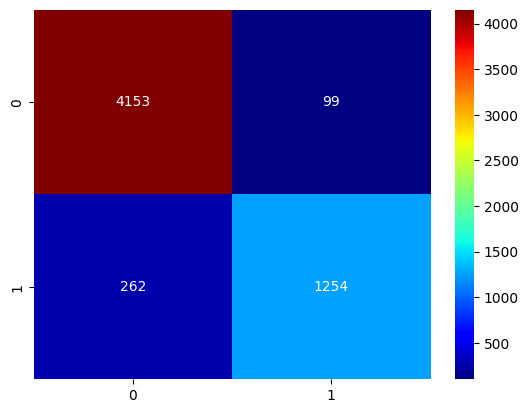

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='jet', cbar=True)
plt.show()

In [20]:
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, confusion_matrix

def plot_metrics(y_pred: np.array, y_test: np.array) -> None:
    '''Plots the confusion matrix, ROC curve and the precision-recall curve.
    
        Takes:
            y_pred: The predicted values (proba)
            y_test: The true values
        Returns: None'''

    y_pred_hard = y_pred > 0.5
    print(classification_report(y_test, y_pred_hard))
    cm = confusion_matrix(y_test, y_pred_hard)
    sns.heatmap(cm, annot=True, fmt='d', cmap='jet', cbar=True)
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.show()

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, precision, linewidth=2, label=None)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall', fontsize=10)
    plt.ylabel('Precision', fontsize=10)
    plt.show()

    plt.plot(thresholds, precision[:-1], "b-", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=10)
    plt.legend(loc="upper left", fontsize=10)
    plt.ylim([0, 1])
    plt.show()

#plot_metrics(y_pred, y_test)

In [19]:
import datetime

In [70]:
with open(f'models/model_{datetime.date.today()}.h5', 'wb') as f:
    pickle.dump(model, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\concatenate
......vars
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dense_4
......vars
.........0
.........1
...layers\input_layer
......vars
...layers\input_layer_1
......vars
...metrics\auc
......vars
.........0
.........1
.........2
.........3
...metrics\mean
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             

In [126]:
input_full = keras.layers.Input(shape=X_train.shape[1:],
                                name='input_full')

hid_full1 = keras.layers.Dense(300, activation='relu',
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.L1(0.001))(input_full)
hid_full2 = keras.layers.Dense(300, activation='relu',
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.L1(0.001))(hid_full1)  
hid_full3 = keras.layers.Dense(50, activation='relu',
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.L1(0.01))(hid_full2)

output_full = keras.layers.Dense(1, activation='sigmoid')(hid_full3)

model_full = keras.Model(inputs=[input_full], outputs=[output_full])


In [127]:
model_full.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_full (InputLayer)     [(None, 1167)]            0         
                                                                 
 dense_61 (Dense)            (None, 300)               350400    
                                                                 
 dense_62 (Dense)            (None, 300)               90300     
                                                                 
 dense_63 (Dense)            (None, 50)                15050     
                                                                 
 dense_64 (Dense)            (None, 1)                 51        
                                                                 
Total params: 455,801
Trainable params: 455,801
Non-trainable params: 0
_________________________________________________________________


In [130]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
model_full.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=METRICS)

In [131]:
model_full.fit(X_train, y_train,
        epochs=100,
        validation_split=0.2,
        verbose=1,
        batch_size=32,
        callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                    tensorboard_callback])

Epoch 1/100
577/577 [==============================] - 11s 15ms/step - loss: 0.5403 - recall: 0.6614 - precision: 0.7060 - auc: 0.8399 - val_loss: 0.5283 - val_recall: 0.7237 - val_precision: 0.6602 - val_auc: 0.8486
Epoch 2/100
577/577 [==============================] - 7s 12ms/step - loss: 0.5247 - recall: 0.6726 - precision: 0.7086 - auc: 0.8446 - val_loss: 0.5179 - val_recall: 0.6883 - val_precision: 0.6810 - val_auc: 0.8532
Epoch 3/100
577/577 [==============================] - 6s 10ms/step - loss: 0.5162 - recall: 0.6663 - precision: 0.7237 - auc: 0.8481 - val_loss: 0.5061 - val_recall: 0.6332 - val_precision: 0.7390 - val_auc: 0.8527
Epoch 4/100
577/577 [==============================] - 5s 9ms/step - loss: 0.5098 - recall: 0.6653 - precision: 0.7222 - auc: 0.8502 - val_loss: 0.5040 - val_recall: 0.6094 - val_precision: 0.7388 - val_auc: 0.8544
Epoch 5/100
577/577 [==============================] - 6s 11ms/step - loss: 0.5055 - recall: 0.6599 - precision: 0.7304 - auc: 0.8515 - 

181/181 [==============================] - 1s 3ms/step
[[0]
 [0]
 [0]
 [0]
 [0]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4224
           1       0.94      0.84      0.89      1544

    accuracy                           0.94      5768
   macro avg       0.94      0.91      0.92      5768
weighted avg       0.94      0.94      0.94      5768



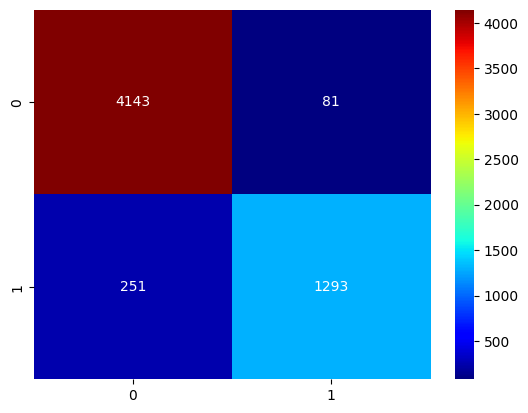

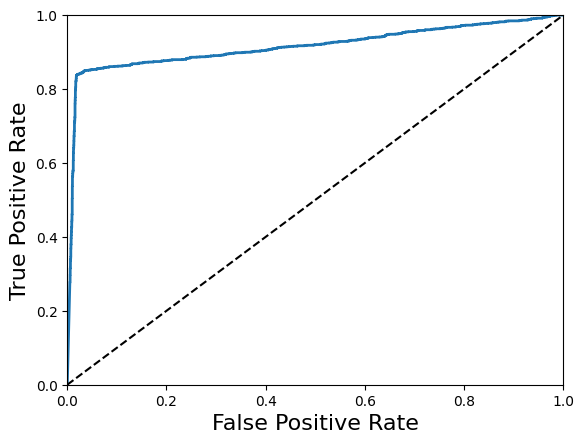

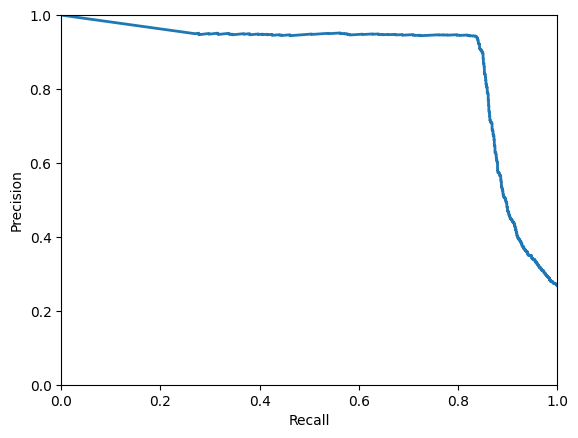

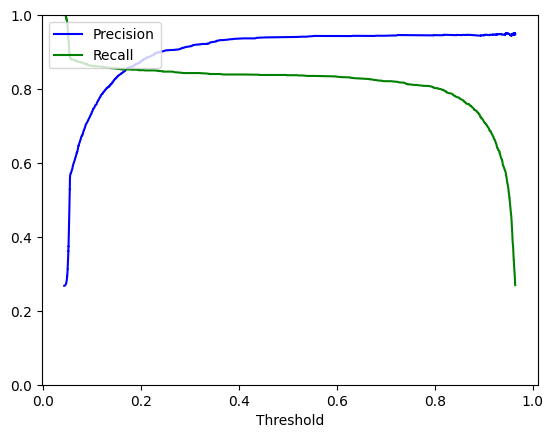

In [132]:
y_pred = model_full.predict(X_test)
y_class = y_pred > 0.5
y_class = y_class.astype('int64')
print(y_class[:5])
print(classification_report(y_test, y_class))

# plot confusion matrix
cm = confusion_matrix(y_test, y_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='jet', cbar=True)
plt.show()

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, linewidth=2, label=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

# plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision, linewidth=2, label=None)
plt.axis([0, 1, 0, 1])
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
plt.show()

# plot precision-recall curve
plt.plot(thresholds, precision[:-1], "b-", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold", fontsize=10)
plt.legend(loc="upper left", fontsize=10)
plt.ylim([0, 1])
plt.show()


In [133]:
with open(f'models/model_full_{datetime.date.today()}.h5', 'wb') as f:
    pickle.dump(model_full, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\input_layer
......vars
...metrics\auc
......vars
.........0
.........1
.........2
.........3
...metrics\mean
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2022-12-25 18:22:25         3846
metadata.json                                  2022-12-25 18:

In [134]:
with open('TrainData/non_filled.pkl', 'rb') as f:
    df = pickle.load(f)

df.head()

,DateOfIncident,IncidentTime,BodilyInjuries,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,CustomerLoyaltyPeriod,DateOfPolicyCoverage,Policy_Deductible,...,VehicleModel_X5,VehicleModel_X6,Witnesses_0.0,Witnesses_1.0,Witnesses_2.0,Witnesses_3.0,NumberOfVehicles_1,NumberOfVehicles_2,NumberOfVehicles_3,NumberOfVehicles_4
0,0.458333,0.739130,0.5,0.569408,0.625501,0.256485,0.577765,0.100418,0.350114,0.333333,...,0,0,1,0,0,0,0,0,1,0
1,0.444444,0.434783,1.0,0.533519,0.725408,0.250063,0.500862,0.236402,0.432058,0.333333,...,0,0,0,1,0,0,0,0,1,0
2,0.194444,0.956522,1.0,0.580335,0.542191,0.491339,0.546072,0.347280,0.441757,0.078000,...,0,0,0,0,0,1,1,0,0,0
3,0.250000,0.956522,1.0,0.575873,0.559580,0.507098,0.530239,0.395397,0.607279,0.148000,...,0,0,0,0,0,1,1,0,0,0
4,0.111111,0.434783,1.0,0.465226,0.411608,0.305619,0.470378,0.238494,0.270568,0.000000,...,0,0,0,1,0,0,1,0,0,0


In [140]:
X = df.drop('ReportedFraud', axis=1)
y = df['ReportedFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [141]:
input_full = keras.layers.Input(shape=X_train.shape[1:],
                                name='input_full')

hid_full1 = keras.layers.Dense(300, activation='relu',
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.L1(0.001))(input_full)
hid_full2 = keras.layers.Dense(300, activation='relu',
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.L1(0.001))(hid_full1)  
hid_full3 = keras.layers.Dense(50, activation='relu',
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.L1(0.01))(hid_full2)

output_full = keras.layers.Dense(1, activation='sigmoid')(hid_full3)

model_full = keras.Model(inputs=[input_full], outputs=[output_full])

model_full.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0007),
                    loss='binary_crossentropy',
                    metrics=METRICS)

tensorboard_callback = get_tb_callback()

In [142]:
model_full.fit(X_train, y_train,
                epochs=100,
                validation_split=0.2,
                verbose=1,
                batch_size=32,
                callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                            tensorboard_callback])

Epoch 1/100
572/572 [==============================] - 9s 14ms/step - loss: 3.6168 - recall: 0.3071 - precision: 0.7885 - auc: 0.8290 - val_loss: 0.5921 - val_recall: 0.6187 - val_precision: 0.6363 - val_auc: 0.8245
Epoch 2/100
572/572 [==============================] - 7s 13ms/step - loss: 0.5636 - recall: 0.6205 - precision: 0.6868 - auc: 0.8303 - val_loss: 0.5443 - val_recall: 0.7260 - val_precision: 0.6765 - val_auc: 0.8456
Epoch 3/100
572/572 [==============================] - 6s 11ms/step - loss: 0.5380 - recall: 0.6543 - precision: 0.7120 - auc: 0.8406 - val_loss: 0.5249 - val_recall: 0.6041 - val_precision: 0.7582 - val_auc: 0.8519
Epoch 4/100
572/572 [==============================] - 6s 10ms/step - loss: 0.5231 - recall: 0.6494 - precision: 0.7175 - auc: 0.8454 - val_loss: 0.5122 - val_recall: 0.6764 - val_precision: 0.7247 - val_auc: 0.8541
Epoch 5/100
572/572 [==============================] - 5s 9ms/step - loss: 0.5139 - recall: 0.6541 - precision: 0.7294 - auc: 0.8480 - v

179/179 [==============================] - 1s 3ms/step
[[1]
 [0]
 [1]
 [0]
 [0]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4148
           1       0.93      0.85      0.89      1566

    accuracy                           0.94      5714
   macro avg       0.94      0.91      0.92      5714
weighted avg       0.94      0.94      0.94      5714



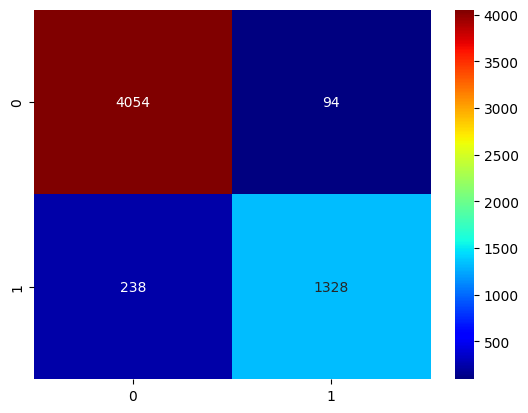

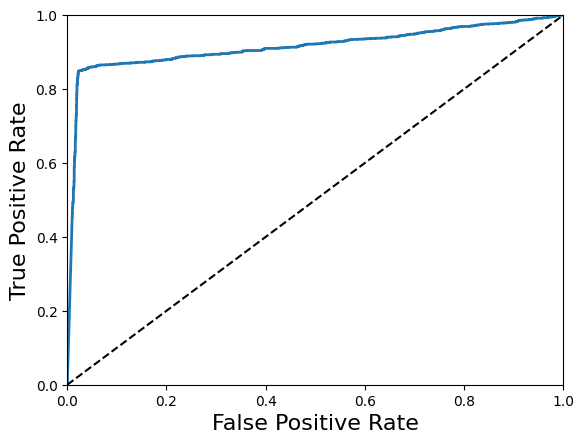

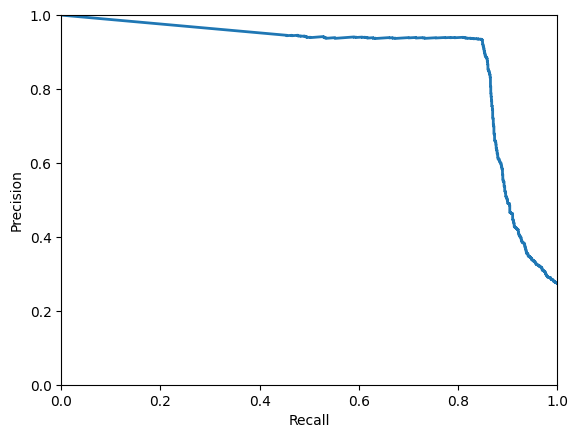

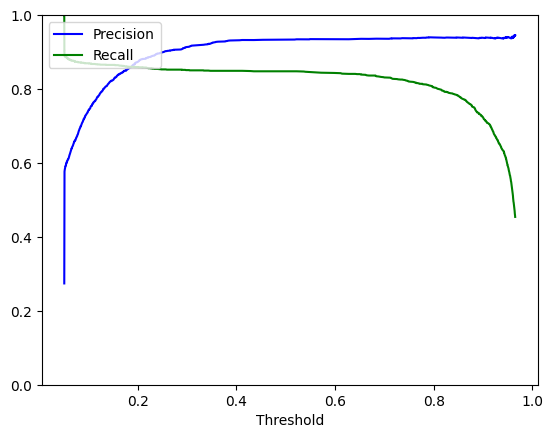

In [143]:
y_pred = model_full.predict(X_test)
y_class = y_pred > 0.5
y_class = y_class.astype('int64')
print(y_class[:5])
print(classification_report(y_test, y_class))

# plot confusion matrix
cm = confusion_matrix(y_test, y_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='jet', cbar=True)
plt.show()

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, linewidth=2, label=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

# plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision, linewidth=2, label=None)
plt.axis([0, 1, 0, 1])
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
plt.show()

# plot precision-recall curve
plt.plot(thresholds, precision[:-1], "b-", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold", fontsize=10)
plt.legend(loc="upper left", fontsize=10)
plt.ylim([0, 1])
plt.show()

In [6]:
with open('TrainData/non_filled_norm.pkl', 'rb') as f:
    data = pickle.load(f)

X = data.drop('ReportedFraud', axis=1)
y = data['ReportedFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
model_bn = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation='elu', kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation='elu', kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation='elu', kernel_initializer='he_normal', use_bias=False),
    keras.layers.Dense(1, activation='sigmoid')
])

model_bn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 1170)             4680      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 500)               585000    
                                                                 
 batch_normalization_4 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 500)               250000    
                                                                 
 batch_normalization_5 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                      

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=0.0007)
model_bn.compile(loss='binary_crossentropy', metrics=METRICS)

In [13]:
model_bn.fit(X_train, y_train,
                batch_size=32,
                epochs=3,
                validation_split=0.2,
                callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), get_tb_callback()])

Epoch 1/3
572/572 [==============================] - 9s 13ms/step - loss: 0.4021 - recall: 0.7625 - precision: 0.8467 - auc: 0.9078 - val_loss: 0.2920 - val_recall: 0.8292 - val_precision: 0.8956 - val_auc: 0.9132
Epoch 2/3
572/572 [==============================] - 8s 14ms/step - loss: 0.2497 - recall: 0.8158 - precision: 0.9120 - auc: 0.9274 - val_loss: 0.3589 - val_recall: 0.8364 - val_precision: 0.8987 - val_auc: 0.9106
Epoch 3/3
572/572 [==============================] - 7s 12ms/step - loss: 0.2231 - recall: 0.8332 - precision: 0.9335 - auc: 0.9391 - val_loss: 0.4038 - val_recall: 0.8364 - val_precision: 0.9186 - val_auc: 0.9092


179/179 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4227
           1       0.93      0.84      0.89      1487

    accuracy                           0.94      5714
   macro avg       0.94      0.91      0.92      5714
weighted avg       0.94      0.94      0.94      5714



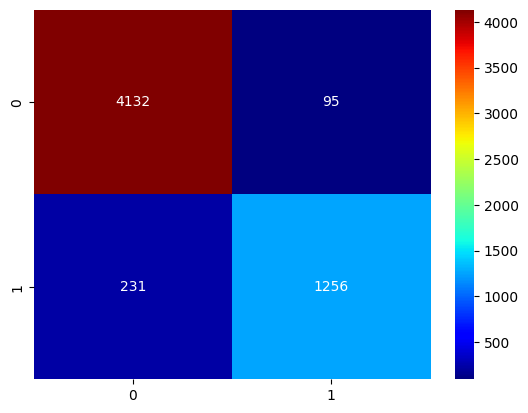

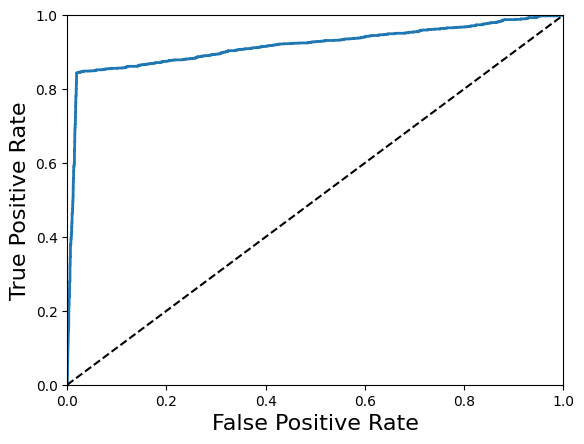

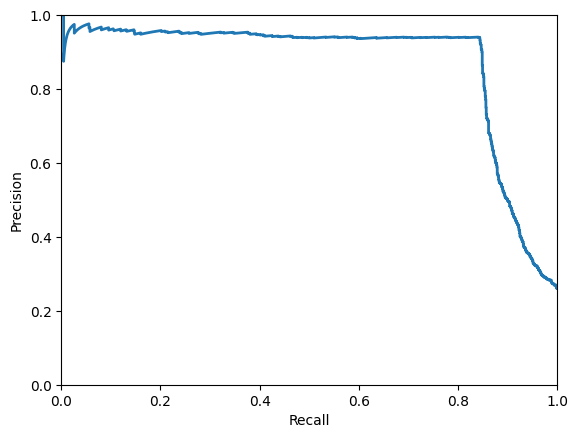

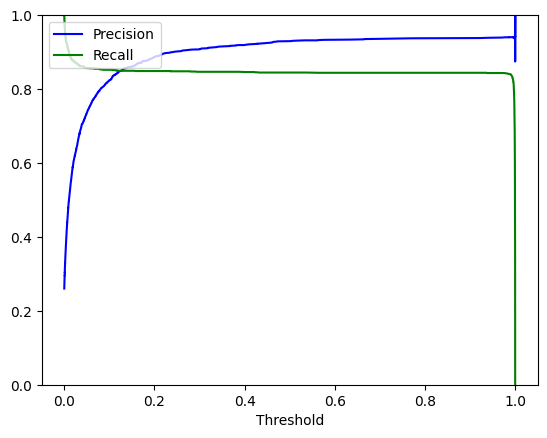

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
y_pred = model_bn.predict(X_test)
plot_metrics(y_pred=y_pred, y_test=y_test)

In [21]:
with open(f'models/model_bn_{datetime.date.today()}.h5', 'wb') as f:
    pickle.dump(model_bn, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\dense
......vars
.........0
...layers\dense_1
......vars
.........0
...layers\dense_2
......vars
.........0
...layers\dense_3
......vars
.........0
.........1
...metrics\auc
......vars
.........0
.........1
.........2
.........3
...metrics\mean
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.j

In [3]:
with open('TrainData/train_inliers.pkl', 'rb') as f:
    inliers = pickle.load(f)

In [6]:
datatypes = pd.DataFrame(inliers.dtypes)
datatypes.columns = ['dtype']
datatypes

,dtype
DateOfIncident,float64
TypeOfIncident,int32
TypeOfCollission,int32
SeverityOfIncident,int32
AuthoritiesContacted,int32
IncidentState,int32
IncidentCity,int32
IncidentAddress,int32
IncidentTime,float64
NumberOfVehicles,int32


In [12]:
cat_cols = (datatypes[datatypes['dtype'] != 'float64']
            .index
            .tolist())
cat_cols.remove('ReportedFraud')

print(cat_cols)

['TypeOfIncident', 'TypeOfCollission', 'SeverityOfIncident', 'AuthoritiesContacted', 'IncidentState', 'IncidentCity', 'IncidentAddress', 'NumberOfVehicles', 'PropertyDamage', 'Witnesses', 'PoliceReport', 'InsurancePolicyState', 'InsuredRelationship', 'InsuredGender', 'InsuredEducationLevel', 'InsuredOccupation', 'InsuredHobbies', 'VehicleMake', 'VehicleModel']


In [13]:
inliers = pd.get_dummies(inliers, columns=cat_cols, drop_first=True)
inliers.head()

,DateOfIncident,IncidentTime,BodilyInjuries,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,CustomerLoyaltyPeriod,DateOfPolicyCoverage,Policy_Deductible,...,VehicleModel_29,VehicleModel_30,VehicleModel_31,VehicleModel_32,VehicleModel_33,VehicleModel_34,VehicleModel_35,VehicleModel_36,VehicleModel_37,VehicleModel_38
0,0.217735,0.851958,0.018118,0.525592,1.373190,-0.277179,0.463147,-1.541739,-0.486356,-0.209070,...,0,0,0,0,0,0,0,0,0,0
1,0.158341,-0.287094,1.292409,0.361359,1.857203,-0.311916,0.123263,-0.891292,-0.172670,-0.209070,...,0,0,0,0,0,0,0,0,0,0
2,-0.910754,1.665567,1.292409,0.575591,0.969581,0.993227,0.323077,-0.360927,-0.135545,-0.909735,...,0,0,0,0,0,0,0,0,0,0
3,-0.673178,1.665567,1.292409,0.555177,1.053826,1.078469,0.253098,-0.130769,0.498085,-0.717647,...,0,0,0,0,0,0,0,0,0,0
4,-1.267120,-0.287094,1.292409,0.048842,0.336953,-0.011397,-0.011466,-0.881285,-0.790865,-1.123777,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(inliers.drop('ReportedFraud', axis=1), inliers['ReportedFraud'], test_size=0.2)

In [15]:
model_inl = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation='elu', kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation='elu', kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation='elu', kernel_initializer='he_normal', use_bias=False),
    keras.layers.Dense(1, activation='sigmoid')
])

model_inl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1147)             4588      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 500)               573500    
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 500)               250000    
                                                                 
 batch_normalization_2 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                        

In [23]:
optimizer = keras.optimizers.Adam(learning_rate=0.0007)
model_inl.compile(loss='binary_crossentropy', metrics=METRICS)

In [26]:
model_inl.fit(X_train, y_train,
                batch_size=32,
                epochs=15,
                validation_split=0.2,
                callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), get_tb_callback()])

Epoch 1/15
502/502 [==============================] - 6s 12ms/step - loss: 0.1774 - recall: 0.8524 - precision: 0.9363 - auc: 0.9643 - val_loss: 0.4517 - val_recall: 0.8581 - val_precision: 0.9254 - val_auc: 0.9200
Epoch 2/15
502/502 [==============================] - 6s 13ms/step - loss: 0.1649 - recall: 0.8592 - precision: 0.9399 - auc: 0.9704 - val_loss: 0.5132 - val_recall: 0.8599 - val_precision: 0.9211 - val_auc: 0.9201
Epoch 3/15
502/502 [==============================] - 6s 12ms/step - loss: 0.1510 - recall: 0.8740 - precision: 0.9352 - auc: 0.9757 - val_loss: 0.5643 - val_recall: 0.8581 - val_precision: 0.9218 - val_auc: 0.9191
Epoch 4/15
502/502 [==============================] - 6s 12ms/step - loss: 0.1412 - recall: 0.8820 - precision: 0.9390 - auc: 0.9788 - val_loss: 0.6036 - val_recall: 0.8581 - val_precision: 0.9076 - val_auc: 0.9184
Epoch 5/15
502/502 [==============================] - 6s 12ms/step - loss: 0.1291 - recall: 0.8906 - precision: 0.9401 - auc: 0.9831 - val_l